In [1]:
import torch
from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# Set random seeds for reproducibility
torch.manual_seed(42)

In [3]:
# Check for GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


In [4]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [5]:
dir_path = 'PlantVillage'

dataset = datasets.ImageFolder(
    root=dir_path,
    transform=transform
)

In [6]:
train_size = int(0.8* len(dataset))
test_size = len(dataset) - train_size

In [7]:
train_ds, test_ds = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(
    train_ds,
    batch_size=32,
    shuffle=True,
    pin_memory=True,
    num_workers=4
)

test_loader = DataLoader(
    test_ds,
    batch_size=32,
    shuffle=False,
    pin_memory=True,
    num_workers=4
)

In [8]:
import numpy as np
import random

In [9]:
class_labels = dataset.classes

In [10]:
def unnormalize(img):
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])

    img = img.permute(1, 2, 0).cpu().numpy()  # C,H,W → H,W,C
    img = std * img + mean
    return np.clip(img, 0, 1)

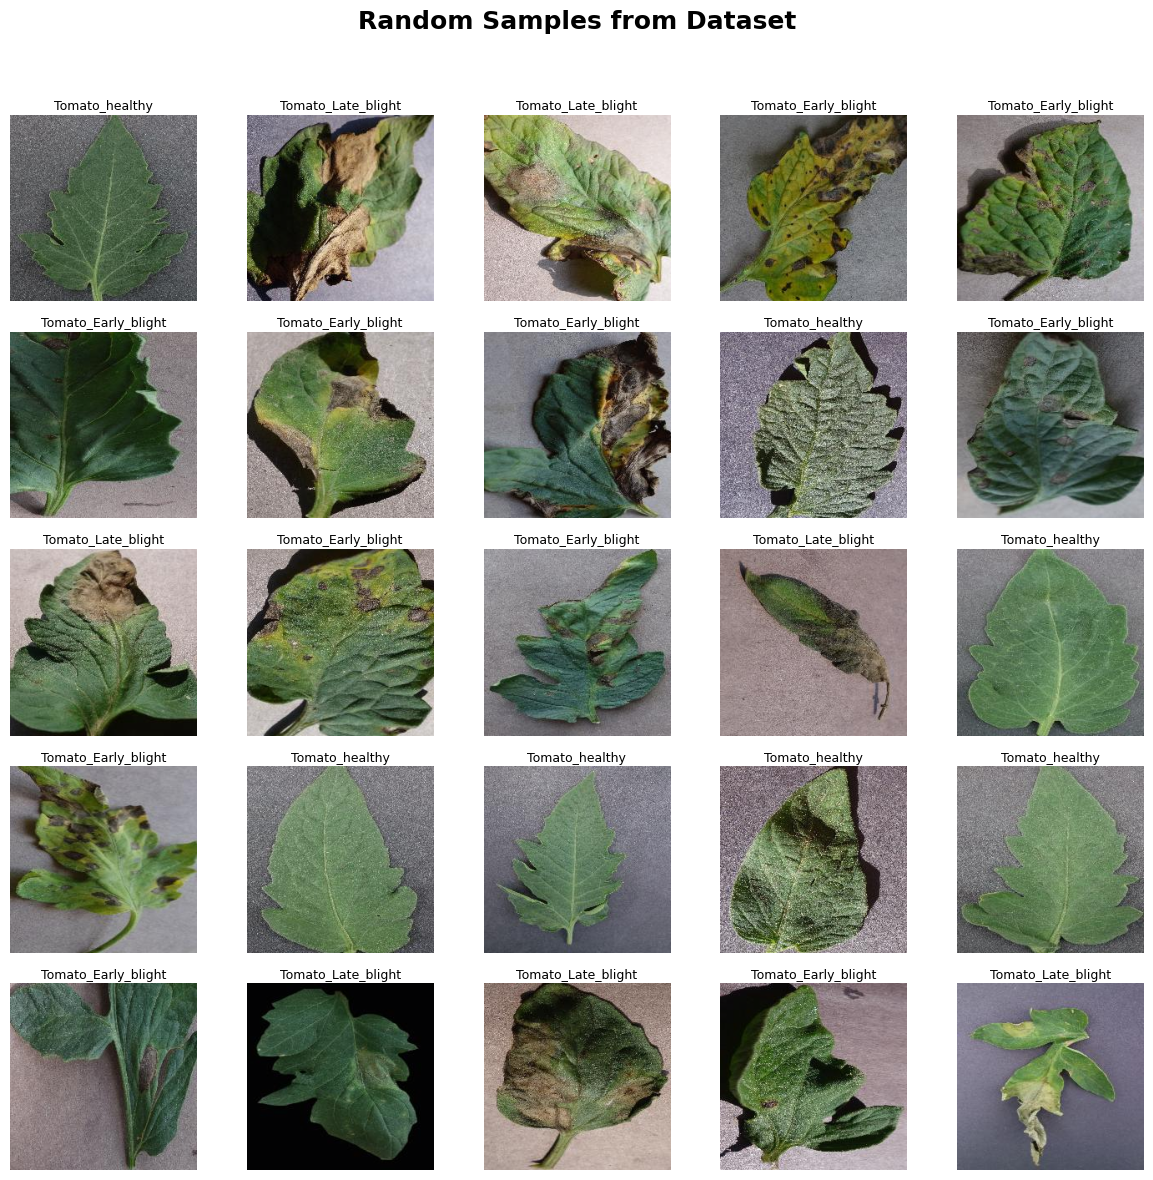

In [11]:
rows, cols = 5, 5
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
fig.suptitle("Random Samples from Dataset", fontsize=18, fontweight="bold")

axes = axes.flatten()

for i in range(rows * cols):
    idx = random.randint(0, len(dataset) - 1)
    img, label_idx = dataset[idx]

    img = unnormalize(img)

    axes[i].imshow(img)
    axes[i].set_title(
        class_labels[label_idx],
        fontsize=9,
        pad=4
    )
    axes[i].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [12]:
import torchvision.models as models

mobilenet = models.mobilenet_v2(weights='IMAGENET1K_V1')

In [13]:
mobilenet

MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [14]:
for param in mobilenet.features.parameters():
    param.requires_grad=False

In [15]:
mobilenet.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(1280, 3)
)

In [17]:
mobilenet.classifier

Sequential(
  (0): Dropout(p=0.2, inplace=False)
  (1): Linear(in_features=1280, out_features=3, bias=True)
)

In [18]:
mobilenet = mobilenet.to(device)

In [19]:
learning_rate = 0.0001

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.classifier.parameters(), lr=learning_rate)

In [22]:
import time

start_time = time.time()

## Create variables to track things
epochs = 10
train_loss = []

## For loop over epochs
for i in range(epochs):
    mobilenet.train()
    epoch_train_loss = 0  ## to calc average train loss over all batches per epoch
        
    ## Train our model
    for b, (X_train, y_train) in enumerate(train_loader, start=1):  ## b=6000, X_train.shape --> torch.Size([10, 1, 28, 28]), y_train.shape --> ([10])
        
        ## move batches to device(cuda)
        X_train = X_train.to(device)
        y_train = y_train.to(device)
        
        y_pred = mobilenet(X_train)
        loss = criterion(y_pred, y_train)
    
        ## Update/ Optimize parameters
        optimizer.zero_grad()  ## gradient = 0 every new batch to avoid gradient accumulation
        loss.backward()  ## calculating new gradients (which feature is more impactful/ which is not etc.)
        optimizer.step()  ## updating parameters

        epoch_train_loss += loss.item()
        
        ## Print results 
        if b%50 == 0:
            print(f'For Epoch: {i+1} Batch: {b}, Loss: {loss.item()}')  ## calc. loss of every 600th batch

    train_loss.append(epoch_train_loss/len(train_loader))   ## Saving average train loss after each epoch

end_time = (time.time() - start_time)/60
print(f'Total time took by our model is, {end_time:.3f} minutes.')

For Epoch: 1 Batch: 50, Loss: 0.8048663139343262
For Epoch: 1 Batch: 100, Loss: 0.7033877372741699
For Epoch: 2 Batch: 50, Loss: 0.44077593088150024
For Epoch: 2 Batch: 100, Loss: 0.3657221794128418
For Epoch: 3 Batch: 50, Loss: 0.44631293416023254
For Epoch: 3 Batch: 100, Loss: 0.5176028609275818
For Epoch: 4 Batch: 50, Loss: 0.326457142829895
For Epoch: 4 Batch: 100, Loss: 0.3862811326980591
For Epoch: 5 Batch: 50, Loss: 0.4810967445373535
For Epoch: 5 Batch: 100, Loss: 0.4026845097541809
For Epoch: 6 Batch: 50, Loss: 0.31882819533348083
For Epoch: 6 Batch: 100, Loss: 0.24234837293624878
For Epoch: 7 Batch: 50, Loss: 0.29285097122192383
For Epoch: 7 Batch: 100, Loss: 0.35553401708602905
For Epoch: 8 Batch: 50, Loss: 0.3276668190956116
For Epoch: 8 Batch: 100, Loss: 0.26014021039009094
For Epoch: 9 Batch: 50, Loss: 0.12671062350273132
For Epoch: 9 Batch: 100, Loss: 0.2057199478149414
For Epoch: 10 Batch: 50, Loss: 0.37822026014328003
For Epoch: 10 Batch: 100, Loss: 0.21944107115268707

In [23]:
mobilenet.eval()

# evaluation on test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = mobilenet(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9588888888888889


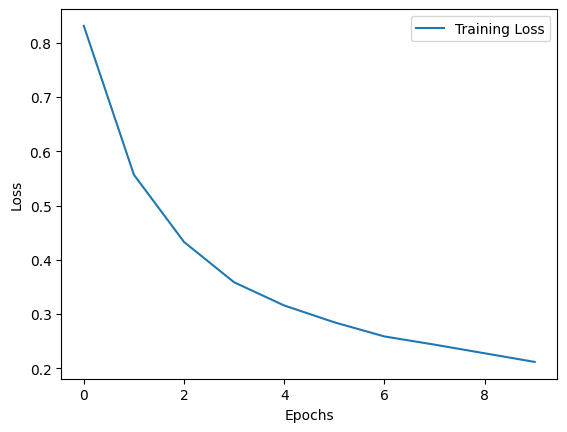

In [24]:
## Plotting results
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

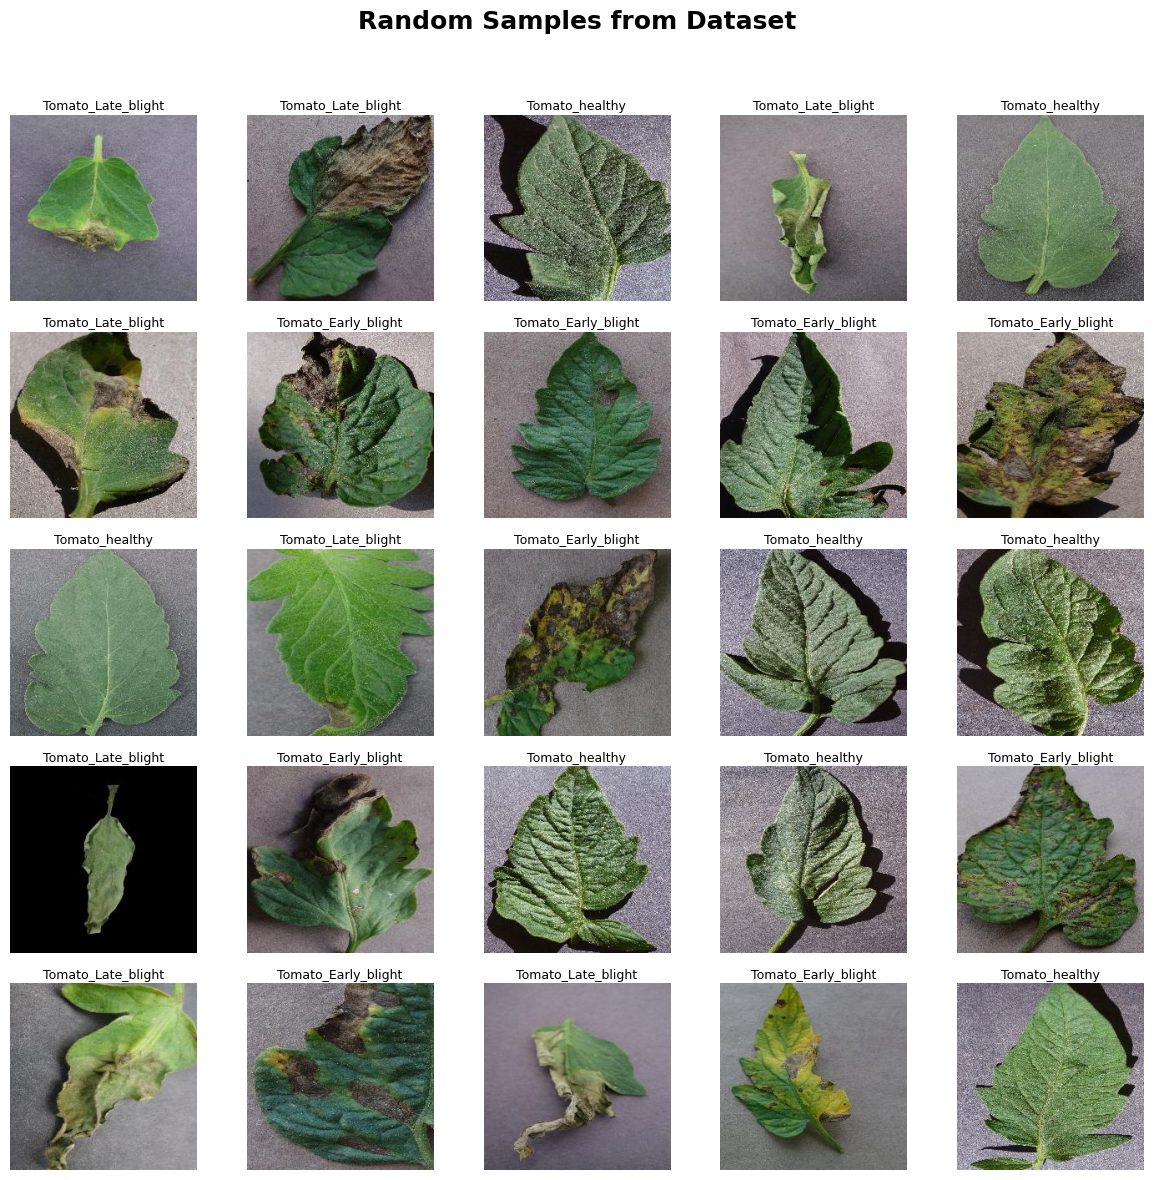

In [25]:
rows, cols = 5, 5
fig, axes = plt.subplots(rows, cols, figsize=(12, 12))
fig.suptitle("Random Samples from Dataset", fontsize=18, fontweight="bold")

axes = axes.flatten()

for i in range(rows * cols):
    idx = random.randint(0, len(dataset) - 1)
    img, _ = dataset[idx]

    img_ = unnormalize(img)

    axes[i].imshow(img_)

    mobilenet.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)
        output = mobilenet(img)

    _, predicted = torch.max(output, 1)
    
    axes[i].set_title(
        class_labels[predicted.item()],
        fontsize=9,
        pad=4
    )
    axes[i].axis("off")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [26]:
## Saving model's trained parameters
torch.save(mobilenet.state_dict(), 'mobilenet_tomato_leaf_detector.pt')